In [ ]:
From Simon Prince,  Computer Vision Models
Algorithm 8.3

In [1]:
%matplotlib inline

import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt; plt.style.use('classic')
import seaborn as sns; sns.set()

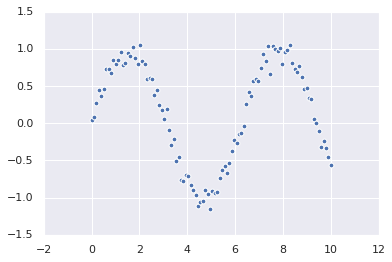

In [2]:
# generate non-linear data
I = 100

x = np.linspace(0, 10, I)

rng = np.random.RandomState(42)
var_w = 0.1
w = np.sin(x) + var_w * rng.randn(I)

plt.scatter(x,w, s=23);

In [3]:
# prepare data for Gaussian process regression

# model:
# mean of observation is linearly dependent on x: 
# phi_0 + phi_1 * x

# prepend 1 to each data point for including constant phi_0. 
X = np.vstack( [np.ones(I), x] )
#print(X)
#print(X.shape)
W = np.asarray(w).reshape(I,1)
#print(W)
#print(W.shape)

In [4]:
# linear kernel
def kernel(X,Y):
    n = X.shape[1]
    m = Y.shape[1]
    #print(n,m)
    
    result = np.zeros((n,m))
    
    for i in range(n):
        for j in range(m):
            result[i][j] = X[:,i].dot(Y[:,j])
    
    return result 

#plt.imshow(kernel(X,X))
#plt.show()

In [5]:
# gaussian kernel
# Parameter:
# - sigma : variance of kernel

sigma = .7 # TODO: un-global-ize

def kernel(X, Y):
    
    n = X.shape[1]
    m = Y.shape[1]
    #print(n,m)
    
    result = np.zeros((n,m))
    
    # TODO: Replace for-loops
    for i in range(n):
        for j in range(m):
            result[i][j] = np.exp(-1/(2*sigma)*(X[:,i]-Y[:,j]).dot(X[:,i]-Y[:,j]))
    
    return result 

#plt.imshow(kernel(X,X))
#plt.show()

In [6]:
# Parameters:
# - var_p : variance of prior of (phi_0, phi_1)
# - K : precalculated matrix kernel(X,X) (TODO: make this cleaner)

var_p = 100 # TODO: un-global-ize

def logpdf_W_with(var):
    cov = var_p * K + var * np.eye(I) # Reuse of K!
    rv = multivariate_normal(np.zeros(I), cov)
    
    return np.linalg.norm(-rv.logpdf(W))

def predict_w_given(x_new):
    # TODO: Implement an optimizer, e.g. line search, instead of doing:
    var_cand = np.linspace(.01, 10, 100)
    var_list = list(map(logpdf_W_with, var_cand))
    index_min = np.argmin(var_list)
    var_min = var_cand[index_min]
    
    A_inv = np.linalg.inv(K + var_min/var_p * np.eye(I)) # Reuse of K!

    mu_pred = kernel(x_new, X).dot(W)
    mu_pred -= kernel(x_new, X).dot(A_inv.dot(K.dot(W)))
    mu_pred = (var_p/var_min) * mu_pred

    var_pred = kernel(x_new, x_new)
    var_pred -= kernel(x_new, X).dot(A_inv.dot(kernel(X, x_new))) 
    var_pred = var_p * var_pred
    var_pred += var_min
    
    return mu_pred, var_pred

In [7]:
def run():
    # prepare new data for prediction
    X_new = np.vstack([np.ones(N), x_new])

    # make predictions for x_new
    result = list(map(predict_w_given, X_new.T.reshape(N,2,1)))

    # plot results:
    
    # data post-processing: is there a cleaner way?
    result = np.asarray(result).reshape(N,2).T
        
    y = result[0]
    dy = result[1]
    
    fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(13, 7))
    
    ax.imshow(K)
    ax.set(title = 'kernel with sigma = %2.3f' %sigma)
    
    ax2.plot(x,w, 'ob', markersize='5')
    #plt.plot(x_new, y, '+r', markersize='5')
    #plt.plot(x, np.sin(x), '-g')
    ax2.plot(x_new, y, '-', color='gray')

    ax2.fill_between(x_new, y-2*dy, y+2*dy, color='gray', alpha=0.2)    
    
    asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
    ax2.set_aspect(asp)
    
    plt.show()

    MSE = np.square(np.subtract(y,np.sin(x_new))).mean() 
    print("MSE: ", MSE)
    
    return MSE



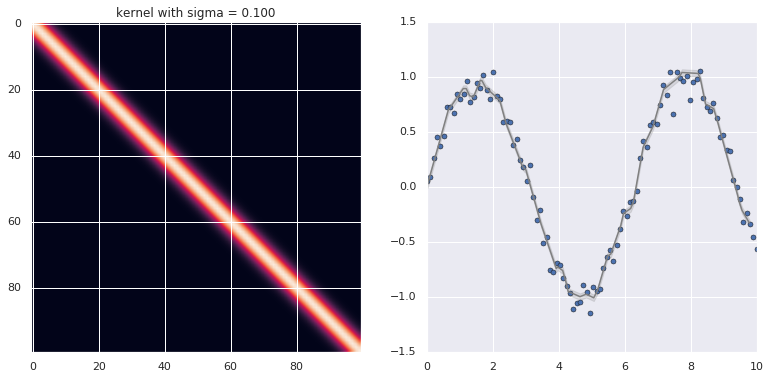

MSE:  0.0042798967501717815


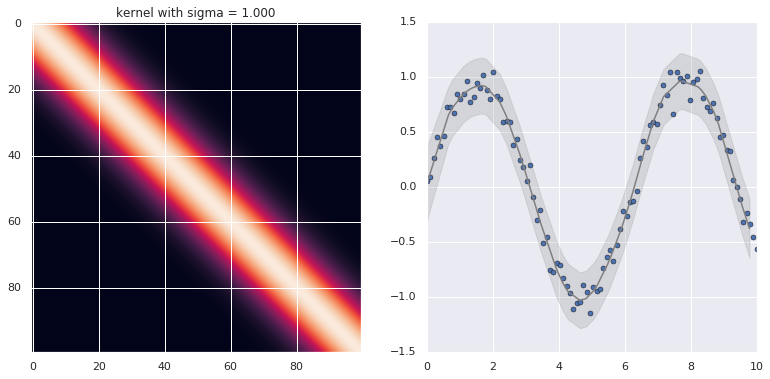

MSE:  0.0012673522099951047


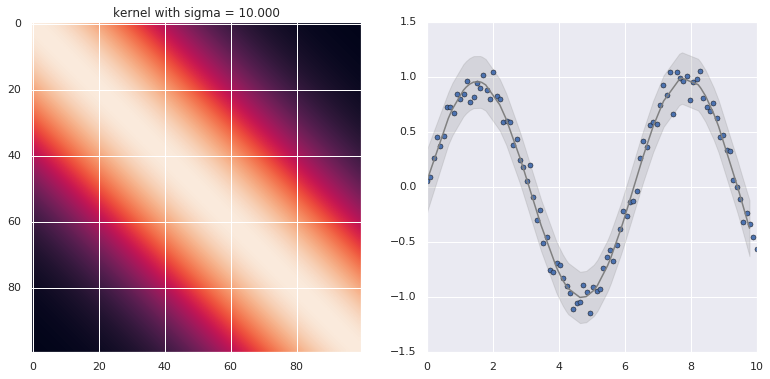

MSE:  0.0006547779415695071


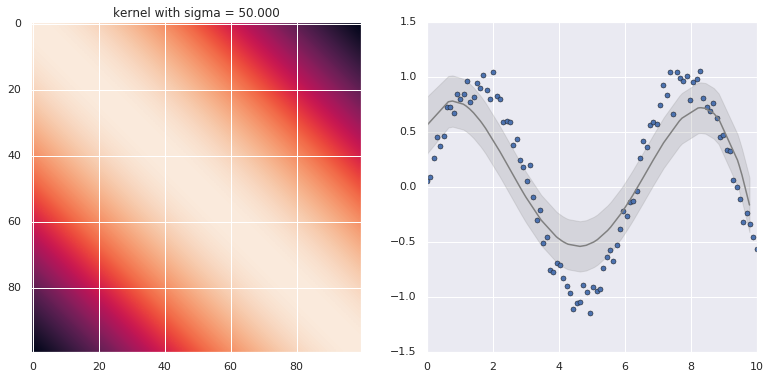

MSE:  0.0915055056649659
CPU times: user 35.2 s, sys: 312 ms, total: 35.5 s
Wall time: 17.8 s


In [8]:
%%time

N = 50
# generate new data x to predict w
#x_new = np.linspace(0, 10, N)
rng = np.random.RandomState(23)
x_new = 10 * rng.rand(N)
x_new = np.sort(x_new)


for sigma in [.1, 1, 10, 50]:        
    # calculate once for reuse in following functions (TODO: make this cleaner)
    K = kernel(X,X)
    run()